# Видеогры

## Установка и подключение библиотек

In [ ]:
!python3 -m pip install vk_api
!python3 -m pip install pyaspeller
!python3 -m pip install pymorphy2
!pip install dostoevsky
!python -m dostoevsky download fasttext-social-network-model
!pip install pyLDAvis
!pip install networkx==1.11
!pip install matplotlib==2.2.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import vk_api
import time
import requests
import pandas as pd
from pymorphy2 import MorphAnalyzer
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pyaspeller import YandexSpeller
import nltk
import re
import sys
from wordcloud import WordCloud
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel
import gensim.corpora as corpora
from gensim.models import LdaMulticore, CoherenceModel
from tqdm import tqdm
from gensim.models import LdaMulticore, CoherenceModel
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
import os
from collections import Counter
import networkx as nx
import warnings
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Парсинг и создание дата фрейма

Парсили данные при помощи PyCharm, Colab почему-то не даёт отправлять запорос через такой код :\

In [ ]:
# def rq(off):
#     data_posts = []
#     vk_config = {"token": "20d20cca23e42227516f682015d848b02bfbd384d1137d20efa3a8d2c556819a41e36e090525dc000887f",
#                  "client_id": "8174809",
#                  "version": "5.131",
#                  "domain": "https://api.vk.com/method/"}

#     count = 100
#     owner_id = -353324

#     for i in range(off, off + 3000, 100):
#         req = requests.get(vk_config["domain"] + "wall.get", params={"access_token": vk_config["token"],
#                                                                     "v": vk_config["version"],
#                                                                      "account_id": vk_config["client_id"],
#                                                                      "owner_id": owner_id,
#                                                                      "count": count,
#                                                                      "offset": off})
#         data = req.json()["response"]["items"]
#         for item in data:
#             data_posts.append(item['text'])
#         time.sleep(0.5)
#     return data_posts

In [ ]:
df = pd.DataFrame(pd.read_csv("dataset.csv"))
df.rename(columns = {"Unnamed: 0": "index", "texts": "text"}, inplace = True)
df.text = df.text.astype('string')
df = df.set_index('index')
df.dropna(inplace = True)

## Предпроцесс

Предпроцесс происходит так:
* приведение к нижнему регистру
* удаляем ссылки
* удаляем эмоджи
* удаление пунктуацию
* исправляем ошибки
* токенизация 
* лемматизация
* удаление стоп-слов

In [ ]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [ ]:
# три функции отчистки 
def clear_from_stopwords(message):
    message = message.split()
    myList = list()
    russian_stopwords = stopwords.words("russian")
    for i in range(0, len(message)):
        if message[i] not in russian_stopwords:
            myList.append(message[i])
    return myList


def clear_message(message):
    clean_text = message
    string_punctuation = string.punctuation + "—" + "«" + "»" + "1" + "2" + "3" + "4" +"5" + "6" + "7" + "8" + "9" + "0"
    for ch in string_punctuation:
        clean_text = clean_text.replace(ch, "")
    return clean_text

def clear_links(message):
    message = re.sub(r'http\S+', '', message)
    return message

In [ ]:
# исправляем ошибки
def spell(message):
    speller = YandexSpeller()
    fixed = speller.spelled(message)
    return fixed

In [ ]:
# токенизируем
def token_by_words(message):
    tokenized = word_tokenize(message)
    return tokenized

In [ ]:
# лемматизация
def lemmatise(message):
    pymorphy2_analyzer = MorphAnalyzer()
    message = ' '.join([pymorphy2_analyzer.parse(w)[0].normal_form for w in message])
    return message

In [ ]:
def pre_process(message):
    message = message.lower()
    message = clear_links(message)
    message = clear_message(message)
    message = remove_emoji(message)
    message = spell(message)
    message = token_by_words(message)
    message = lemmatise(message)
    message = clear_from_stopwords(message)
    return message

In [ ]:
df["pre"] = ""
for i in range(0, len(df)):
   df.pre.iloc[i] = pre_process(df.text.iloc[i])

## Облако Слов

In [ ]:
all_words = []
for i in range(0, len(df)):
    all_words.extend(df.pre.iloc[i])

In [ ]:
counted_words = dict(Counter(all_words))
len(counted_words)

1102

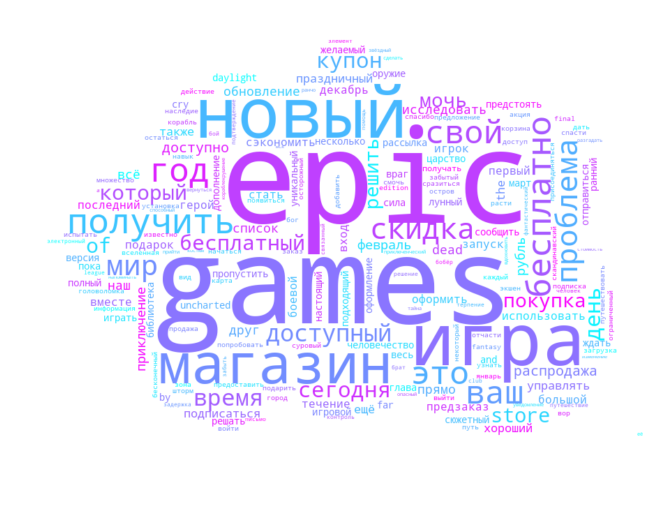

In [ ]:
url = 'https://www.pinclipart.com/picdir/middle/519-5194083_cloud-clipart.png'
# https://psv4.userapi.com/c237331/u31556697/docs/d19/0c645e0a7cb7/IMG_2187.png?extra=Z2RFG27eRO8O_577oxCW2LxfL1tVVdp7B9aoCD388Z3ansP5jFNs2eE8UGEDh9gcYgw0rY_Cy2xzsxHVoUA3-LlTFH3js7T6ycch8PIq0kGofN02NiLRPPd6TM3jm_ZJgsjJYDCJN4m_xKD8R7RAh_Q
response = requests.get(url)
game_mask = np.array(Image.open(BytesIO(response.content)))

wc = WordCloud(background_color="white", max_words=200, mask=game_mask, colormap='cool')
wc.generate_from_frequencies(counted_words)

plt.figure(figsize=(11, 11))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

Так как мы парсили данные по теме игр с группы ВК, созданной компанией Epic Games Store, очевидным результатом оказалось, что среди самых частоиспользуемых слов название платформы онлайн-дистрибьюции

## Частотный анализ униграмм

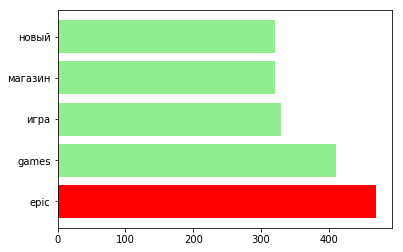

In [ ]:
res = pd.DataFrame(all_words, columns={'word'})
res['number'] = 1
res = res.groupby("word", as_index=False)['number'].count()
vis = res.nlargest(5, columns={'number'})

colors =["red"] + ["lightgreen" for _ in range(4)]
plt.barh(y=vis.word, width=vis.number, color=colors)
plt.show()

Более конкретно видны самые частые слова. Ничего нового ожидать и не стоило

## Анализ тональности

In [ ]:
tokenizer = RegexTokenizer()
model = FastTextSocialNetworkModel(tokenizer=tokenizer)

In [ ]:
itog = pd.DataFrame(set(all_words), columns={'word'})

results = model.predict(all_words, k=1)
sent = []

for message, sentiment in zip(counted_words, results):
    sent.append(list(sentiment.keys())[0])

itog["sentiment"] = sent

In [ ]:
itog['number'] = 1
itog = itog.groupby('sentiment', as_index=False)['number'].count()
itog = itog.sort_values('number', ascending=False)

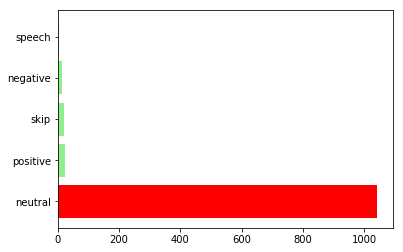

In [ ]:
colors = ["red"] + ["lightgreen" for _ in range(4)]
plt.barh(y=itog.sentiment, width=itog.number, color=colors)
plt.show()

Как показано на графике - преобладает нейтральный тип речи

## Частотный анализ биграмм

In [ ]:
def find_bigram(message):
  message = message.lower()
  message = clear_links(message)
  message = clear_message(message)
  message = remove_emoji(message)
  message = spell(message)
  message = token_by_words(message)
  return list(nltk.bigrams(message))

In [ ]:
df['bigrams'] = ""
for i in range(0, len(df)):
  df.bigrams.iloc[i] = find_bigram(df.text.iloc[i])

In [ ]:
all_bigrams = []
for i in range(0, len(df)):
    all_bigrams.extend(df.bigrams.iloc[i])

In [ ]:
all_bigrams

In [ ]:
all_bigrams_listed = list()

for i in range(0, len(all_bigrams)):
  temp = all_bigrams[i][0] + " "
  temp += all_bigrams[i][1]
  all_bigrams_listed.append(temp)

all_bigrams_listed

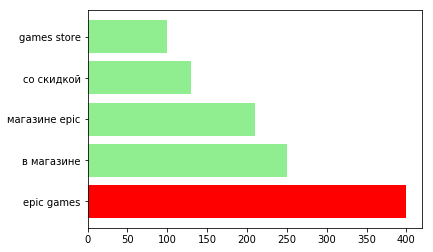

In [ ]:
result = pd.DataFrame(all_bigrams_listed, columns={'bigram'})
result['number'] = 1
result = result.groupby('bigram', as_index=False)['number'].count()
visual = result.nlargest(5, columns={'number'})

colors = ["red"] + ["lightgreen" for _ in range(4)]
plt.barh(y=visual.bigram, width=visual.number, color=colors)
plt.show()

Видно, что с большим отрывом преобладает биграмма "epic games". Результат также кажется достаточно предсказуемым

## Тематический анализ

In [ ]:
id2word = corpora.Dictionary(df.pre.tolist())
texts = df.pre.tolist()
corpus = [id2word.doc2bow(text) for text in texts]

warnings.filterwarnings("ignore")

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model=LdaMulticore(corpus=corpus,id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
	

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=20, step=1)

In [ ]:
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Количество тем")
plt.ylabel("Согласованность")
plt.legend(("coherence_values"), loc='best')
plt.grid()
plt.show()

In [ ]:
n_topics = 8
lda_model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=n_topics)

In [ ]:
lda_model.print_topics()

In [ ]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.088325  0.105731       1        1  32.611096
1      0.035093 -0.031663       2        1  20.866090
2     -0.147466  0.105282       3        1  16.938459
3     -0.077510 -0.142474       4        1  14.841539
4      0.101559 -0.036876       5        1  14.742815, topic_info=           Term        Freq       Total Category  logprob  loglift
60    бесплатно  206.000000  206.000000  Default  30.0000  30.0000
3      проблема  152.000000  152.000000  Default  29.0000  29.0000
78          ваш  179.000000  179.000000  Default  28.0000  28.0000
219       прямо   70.000000   70.000000  Default  27.0000  27.0000
123       купон  116.000000  116.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
370        день   18.934438  125.173068   Topic5  -5.1227   0.0257
109       время   18.855446  133.469405   Topic5  -5.1269  -0.0427
178  распродажа   17.191212   86.569693   Topic5  -5.2193   0.2979
13          это   17.204645  179.389756   Topic5  -5.2185  -0.4300
33         игра   17.065318  303.689253   Topic5  -5.2267  -0.9645

[377 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1017      3  0.975748    architect
913       1  0.049078  battlefield
913       3  0.932489  battlefield
439       1  0.259046           by
439       2  0.051809           by
...     ...       ...          ...
831       5  0.849750      🤩четырь
832       2  0.094347       🦕новый
832       5  0.849122       🦕новый
833       2  0.094128   🦖расширить
833       5  0.847150   🦖расширить

[646 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

In [ ]:
lda_model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=5)
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.145368  0.105312       1        1  22.411664
2     -0.036881 -0.121203       2        1  20.197618
3     -0.158092  0.119149       3        1  19.746042
1      0.062186 -0.029983       4        1  19.202249
0     -0.012582 -0.073274       5        1  18.442427, topic_info=            Term        Freq       Total Category  logprob  loglift
3       проблема  160.000000  160.000000  Default  30.0000  30.0000
141         друг   68.000000   68.000000  Default  29.0000  29.0000
83      сообщить   41.000000   41.000000  Default  28.0000  28.0000
79          вход   50.000000   50.000000  Default  27.0000  27.0000
23         новый  297.000000  297.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
424          всё   18.041463   66.529432   Topic5  -5.3949   0.3855
539          and   16.421531   38.574494   Topic5  -5.4890   0.8365
179      сегодня   17.836380  113.586125   Topic5  -5.4064  -0.1608
71   приключение   16.954264   77.650888   Topic5  -5.4571   0.1688
35       который   16.897947  105.361102   Topic5  -5.4604  -0.1397

[376 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
539       1  0.285163        and
539       3  0.103695        and
539       4  0.181467        and
539       5  0.414782        and
1017      1  0.772997  architect
...     ...       ...        ...
13        2  0.225620        это
13        3  0.146653        это
13        4  0.298947        это
13        5  0.236902        это
818       2  0.928188         🧛‍

[695 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 2, 1])

Можно выделить следуюущие темы:
  - Оповещение о различных проблемах, багах
  - Сам магазин Epic Games
  - Оповещение о раздачах, скидках и тп.
  - Информация о доступе новой игры
  - О шутер-приключении

## Графы

In [ ]:
pairs = []
for doc in df.pre.tolist():
  if doc:
    b = list((nltk.bigrams(doc)))
    if b:
      pairs.extend(b)
len(pairs)

20560

In [ ]:
pairs = [tuple(sorted(pair)) for pair in pairs]

In [ ]:
word_pairs = dict(Counter(pairs))
print(len(word_pairs))

1787


In [ ]:
word_pairs = [(pair[0], pair[1], val) for pair, val in word_pairs.items() if val > 10]
print(len(word_pairs))
word_pairs[:10]

124


[('проблема', 'решить', 50),
 ('проблема', 'связанный', 20),
 ('письмо', 'электронный', 20),
 ('письмо', 'подтверждение', 20),
 ('проблема', 'решение', 20),
 ('отправиться', 'предстоять', 20),
 ('головоломка', 'решать', 30),
 ('epic', 'games', 400),
 ('games', 'store', 100),
 ('вход', 'проблема', 40)]

In [ ]:
G = nx.Graph()
edges = word_pairs
edges[:10], len(edges)

([('проблема', 'решить', 50),
  ('проблема', 'связанный', 20),
  ('письмо', 'электронный', 20),
  ('письмо', 'подтверждение', 20),
  ('проблема', 'решение', 20),
  ('отправиться', 'предстоять', 20),
  ('головоломка', 'решать', 30),
  ('epic', 'games', 400),
  ('games', 'store', 100),
  ('вход', 'проблема', 40)],
 124)

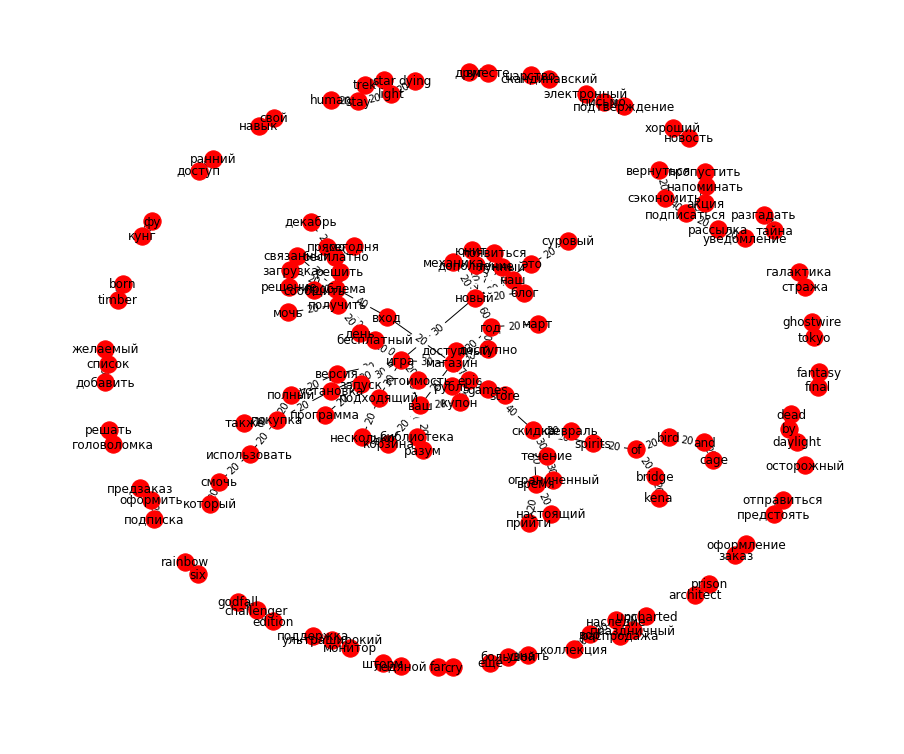

In [ ]:
plt.figure(figsize=(12,10))
G.add_weighted_edges_from(edges)
labels = nx.get_edge_attributes(G, "weight")
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()

In [ ]:
remove = [node for node, degree in dict(G.degree()).items() if degree < 2]
G.remove_nodes_from(remove)

In [ ]:
remove_edge = [pair for pair in G.edges() if pair[0] in remove and pair[1] in remove]
G.remove_edges_from(remove_edge)

In [ ]:
remove = [node for node, degree in dict(G.degree()).items() if degree < 1]
G.remove_nodes_from(remove)

In [ ]:
node_sizes = [deg*50 for node, deg in G.degree().items()]

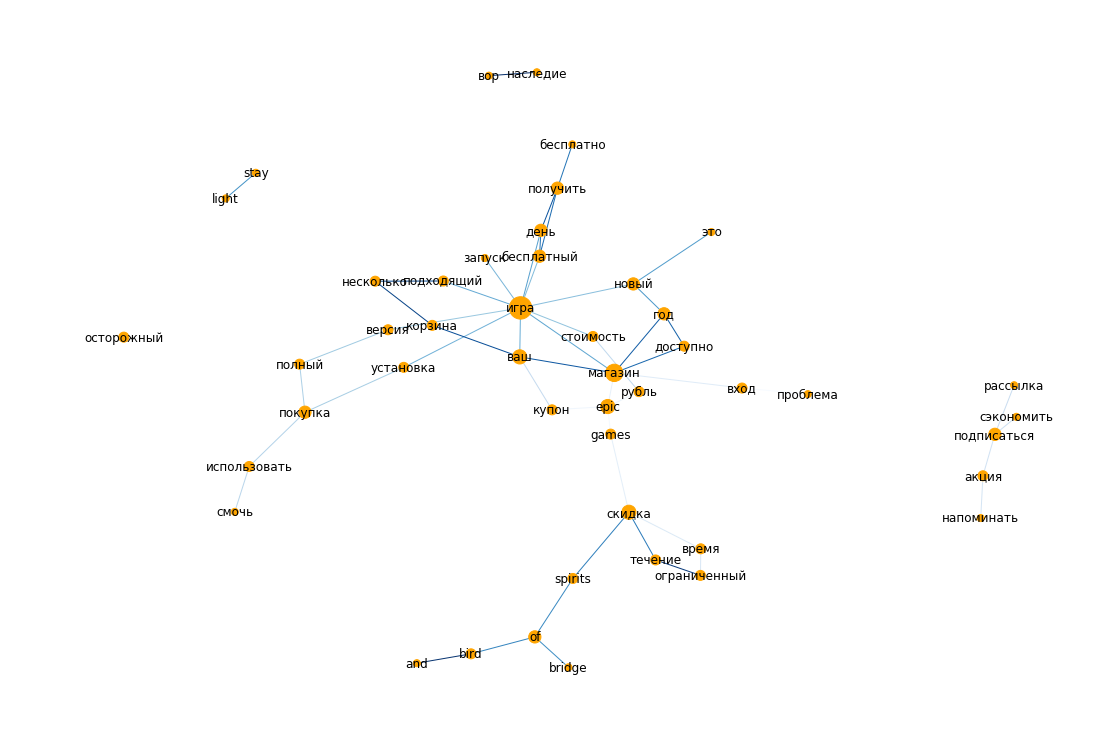

In [ ]:
plt.figure(figsize=(15,10))
pos = nx.layout.spring_layout(G)
edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
nx.draw(G, pos, node_color='orange', node_size=node_sizes, edgelist=G.edges(), edge_color=range(len(G.edges())), width=1.0, with_labels=True, edge_cmap=plt.cm.Blues)
plt.show()

Главная ветка содержит все слова, которые тесно относятся к игре, как к товару и предмету пользования: игра -> (стоимость, корзина, запуск, установка, версия и тп.)

Однако здесь еще явно выделяются две темы:
  - Напоминания об акциях
  - Информация об ограничении действия скидки